In [7]:
import matplotlib.pyplot as plt

Folderpath = "images/"

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.metrics import MeanSquaredError


# Define the CNN model
input_shape = (360, 540, 3)
output_size = 150
model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),

        # Output layer with 100 outputs bounded in the specified range
        layers.Dense(output_size, activation='sigmoid'),
    ])
model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

# # Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 358, 538, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 179, 269, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 177, 267, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 88, 133, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 86, 131, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 65, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 357760)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    91,586,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150)            │        19,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,732,310 (349.93 MB)

 Trainable params: 91,732,310 (349.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import cv2
import numpy as np
def show_image(img, title="image"):
    cv2.imshow(title, img)
    cv2.waitKey(1)

def mainLineDetector(image):
    # converting to hsv
    working_image = image
    hsv_img = cv2.cvtColor(working_image,cv2.COLOR_BGR2HSV)
    # perform masking
    low = [0, 124, 79]
    high = [179, 193, 217]

    mask = cv2.inRange(hsv_img, np.array(low), np.array(high))
    hsv_gray = cv2.bitwise_or(working_image, image, mask=mask)
    hsv_gray = cv2.cvtColor(hsv_gray, cv2.COLOR_BGR2GRAY)

    # finding the contours
    contours, _ = cv2.findContours(hsv_gray, cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)
    # finding the largets contour
    main_line_contour = []
    if len(contours) > 0:
        main_line_contour.append(sorted(contours, key=cv2.contourArea)[-1])
    return main_line_contour
    

def sideLinesDetector(image):
    # cropping to avoid the misleading of buildings
    y = 150 # starting height of the cropping picture
    # height and width of image
    h = image.shape[0]
    w = image.shape[1]
    working_image = image[h-y:, :, :]
    # converting to hsv
    hsv_img = cv2.cvtColor(working_image,cv2.COLOR_BGR2HSV)

    
    # perform masking
    low = [83, 0, 155]
    high = [179, 31, 255]

    mask = cv2.inRange(hsv_img, np.array(low), np.array(high))
    hsv_gray = cv2.bitwise_and(working_image, working_image, mask=mask)
    hsv_gray = cv2.cvtColor(hsv_gray, cv2.COLOR_BGR2GRAY)
    
    # using contour to find the contours in the image
    contours, _ = cv2.findContours(hsv_gray, cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)
    base_img = np.zeros_like(working_image)
    for cnt in contours : 
        area = cv2.contourArea(cnt) 
    
        # Shortlisting the regions based on there area. (area of the side lines) 
        if area > 1: 
            approx = cv2.approxPolyDP(cnt,  
                                    0.009 * cv2.arcLength(cnt, True), True) 
    
            # Checking if the no. of sides of the selected region is 7. 
            cv2.drawContours(base_img, [approx], -1, color=255, thickness=cv2.FILLED) 
    
    # Apply dilation to bridge gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50 , 50))  # Adjust kernel size as needed
    dilated = cv2.dilate(base_img, kernel, iterations=1)
    dilated_gray = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
   
    # Find the new unified contour
    unified_contours, _ = cv2.findContours(dilated_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = []
    temp = []
    if len(unified_contours) >= 2:
        temp = sorted(contours, key=cv2.contourArea)
        temp = [temp[-1], temp[-2]]
    for contour in temp:
        new_contour = contour + np.array([[[0, h-y]]], dtype=np.int32)
        new_contours.append(new_contour)
    return new_contours


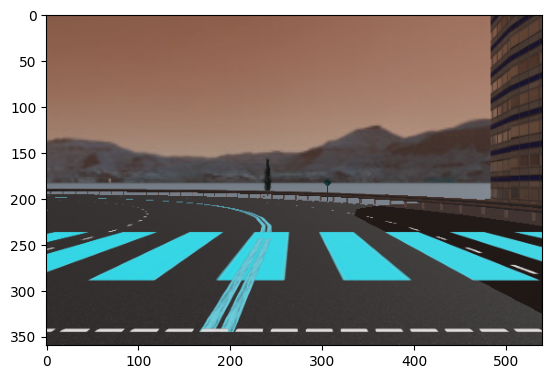

In [10]:
image_sample = cv2.imread(Folderpath + "view01.png")

plt.imshow(image_sample)

In [11]:
# try the cnn model
image = image_sample / 255.0                         # Normalize to [0, 1]
image = np.expand_dims(image, axis=0)                # Add batch dimension (1, H, W, C)
print(image.shape)
predictions = model.predict(image)  # Use the preprocessed input
print(len(predictions[0]))

(1, 360, 540, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
150


In [12]:
model.save("small_cnn_model2.h5")